# HDBSCAN Clustering for RBD sequences
---
### DEMO
https://scikit-learn.org/stable/auto_examples/cluster/plot_hdbscan.html#sphx-glr-auto-examples-cluster-plot-hdbscan-py
--- 
### Parquet Making
We will be making a parquet for the entire file. Then we can sample from it randomly.

In [1]:
import os
import tqdm
import torch
import pickle
import numpy as np
import pandas as pd
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, EsmModel

import hdbscan
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from umap import UMAP
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, adjusted_rand_score

/data/miniconda3/envs/spike_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Merging the metadata with the sequence data.

In [2]:
data_dir = "../../data/rbd"

csv_file = os.path.join(data_dir, f"spikeprot0528.clean.uniq.noX.RBD.metadata.variants.csv")
df = pd.read_csv(csv_file, header=0, low_memory=False)
df

,seq_id,sequence,variant
0,EPI_ISL_5120698,RVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVAD...,Delta
1,EPI_ISL_5123727,RVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVAD...,Delta
2,EPI_ISL_14904955,RVQPTESIVRFPNITNLCPFDEVFNATRFASVYAWNRKRISNCVAD...,Omicron
3,EPI_ISL_5119677,RVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVAD...,Delta
4,EPI_ISL_14904971,RVQPTESIVRFPNITNLCPFDEVFNATRFASVYAWNRKRISNCVAD...,Omicron
...,...,...,...
347427,EPI_ISL_14903692,RVQPTESIVRFPNITNLCPFDEVFNATRFASVYAWNRKRISNCVAD...,Omicron
347428,EPI_ISL_14902388,RVQPTESIVRFPNITNLCPFDEVFNATTFASVYAWNRKRISNCVAD...,Omicron
347429,EPI_ISL_14905423,RVQPTESIVRFPNITNLCPFDEVFNATRFASVYAWNRKRISNCVAD...,Omicron
347430,EPI_ISL_5123715,RVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVAD...,Delta


In [24]:
meta_data = os.path.join(data_dir, f"original/spikeprot0528.clean.uniq.noX.RBD.metadata.tsv")
metadata_df = pd.read_csv(meta_data, sep='\t', header=0, low_memory=False)
metadata_df = metadata_df.rename(columns={'Accession ID': 'seq_id'})
metadata_df = metadata_df[['seq_id', 'Pango lineage', 'Location', 'Collection date', 'AA Substitutions']]

merged_df = pd.merge(df, metadata_df, on='seq_id', how='left')

print(merged_df['variant'].value_counts())
merged_df.head(5)

variant
Omicron    160016
Delta      109448
UNKNOWN     40917
Alpha       22075
Gamma        5978
Iota         2044
Epsilon      1915
Beta         1342
Lambda        985
Mu            939
Eta           611
Zeta          578
Kappa         505
GH/490R        57
Theta          22
Name: count, dtype: int64


,seq_id,sequence,variant,Pango lineage,Location,Collection date,AA Substitutions
0,EPI_ISL_5120698,RVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVAD...,Delta,B.1.617.2,Europe / Germany / Berlin,2021-10-06,"(NSP1_V54del,NSP3_A1321del,N_G215C,NSP3_S1314d..."
1,EPI_ISL_5123727,RVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVAD...,Delta,AY.4,Europe / United Kingdom / England,2021-10-08,"(N_G215C,NSP3_A1711V,Spike_T95I,N_D63G,N_R203M..."
2,EPI_ISL_14904955,RVQPTESIVRFPNITNLCPFDEVFNATRFASVYAWNRKRISNCVAD...,Omicron,BA.5.5,North America / USA / Maryland,2022-08-22,"(NSP5_P132H,Spike_H69del,NSP3_G489S,Spike_L24d..."
3,EPI_ISL_5119677,RVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVAD...,Delta,AY.126,Europe / Germany / Lower Saxony,2021-09-30,"(N_G215C,Spike_T95I,N_D63G,N_R203M,NSP12_G671S..."
4,EPI_ISL_14904971,RVQPTESIVRFPNITNLCPFDEVFNATRFASVYAWNRKRISNCVAD...,Omicron,BA.5.6,North America / USA / California,2022-08-22,"(NSP5_P132H,Spike_H69del,NSP3_G489S,Spike_L24d..."


In [21]:
ado_df = merged_df[merged_df['variant'].isin(["Alpha", "Delta", "Omicron"])]
save_as = os.path.join(data_dir, f"spikeprot0528.clean.uniq.noX.RBD.metadata.variants.ADO.csv")
ado_df.to_csv(save_as, index=False)
ado_df['variant'].value_counts()

variant
Omicron    160016
Delta      109448
Alpha       22075
Name: count, dtype: int64

Making the parquet.

In [26]:
# Parquet Making
class RBDDataset(Dataset):
    """ BetaCorona virus sequence dataset, embedded with ESM model. """

    def __init__(self, csv_file:str):
        self.df = pd.read_csv(csv_file, header=0, na_filter=False)
        self.max_sequence_length = self.df['sequence'].apply(len).max()

    def __len__(self) -> int:
        return len(self.df)

    def __getitem__(self, idx):
        columns = (
            self.df.iloc[idx]["seq_id"],
            self.df.iloc[idx]["variant"],
            self.df.iloc[idx]["Pango lineage"],
            self.df.iloc[idx]["Location"],
            self.df.iloc[idx]["Collection date"],
            self.df.iloc[idx]["AA Substitutions"],
            self.df.iloc[idx]["sequence"],
        )
        return columns

class ESM(nn.Module):
    def __init__(self, esm):
        super().__init__()
        self.esm = esm

    def forward(self, tokenized_seqs):
        with torch.set_grad_enabled(self.training):  # Enable gradients, managed by model.eval() or model.train() in epoch_iteration
            last_hidden_states = self.esm(**tokenized_seqs).last_hidden_state # shape: (batch_size, sequence_length, embedding_dim)
            cls_embedding = last_hidden_states[:, 0, :]  # CLS token embedding (sequence-level representations)
        return cls_embedding

def run_model(model, tokenizer, dataloader, device, csv_file):   
    """ Call the ESM model to generate hidden states and store batch data in DataFrame directly. """
    
    model = model.to(device)
    model.eval()

    # Set the tqdm progress bar
    data_iter = tqdm.tqdm(enumerate(dataloader),
                          total = len(dataloader),
                          bar_format='{l_bar}{r_bar}')

    batch_dataframes = []

    for _, batch_data in data_iter:
        seq_ids, variants, pango_lineages, locations, collection_dates, aa_subs, sequences = batch_data 

        # Add 2 to max_length to account for additional tokens added to beginning and end by ESM
        max_length = dataloader.dataset.max_sequence_length + 2
        tokenized_seqs = tokenizer(sequences, return_tensors='pt', padding='max_length', max_length=max_length).to(device) 
        
        with torch.no_grad():
            embeddings = model(tokenized_seqs) # shape: [batch_size, sequence_len, embedding_dim]

        # Create a DataFrame for the batch
        batch_df = pd.DataFrame({
            "seq_id": seq_ids,
            "variant": variants,
            "Pango lineage": pango_lineages,
            "Location": locations,
            "Collection date": collection_dates,
            "AA Substitutions": aa_subs,
            "embedding": [embedding.cpu().numpy() for embedding in embeddings]  # Convert tensor to numpy array for each embedding
        })

        batch_dataframes.append(batch_df)

    # Concatenate all batch DataFrames into one
    result_df = pd.concat(batch_dataframes, ignore_index=True)
    
    # Save data to a Parquet file
    save_as = csv_file.replace(".csv", "_CLS-embedded.parquet")
    result_df.to_parquet(save_as, index=False)
    print(f"Data saved to {save_as}")

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size = 64

# Data file
data_dir = "../../data/rbd"
csv_file = os.path.join(data_dir, "spikeprot0528.clean.uniq.noX.RBD.metadata.variants.ADO.csv")
dataset = RBDDataset(csv_file)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=False)

# ESM input
esm_version = "facebook/esm2_t6_8M_UR50D"
esm = EsmModel.from_pretrained(esm_version, cache_dir='../model_downloads').to(device)
tokenizer = AutoTokenizer.from_pretrained(esm_version, cache_dir='../model_downloads')

model = ESM(esm)
run_model(model, tokenizer, dataloader, device, csv_file)

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.weight', 'esm.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|| 4556/4556 [05:39<00:00, 13.42it/s]


Data saved to ../../data/rbd/spikeprot0528.clean.uniq.noX.RBD.metadata.variants.ADO_CLS-embedded.parquet


### Clustering - tSNE, then HDBSCAN
Sampling from the embeddings.

In [66]:
parquet_file = os.path.join(data_dir, "spikeprot0528.clean.uniq.noX.RBD.metadata.variants.ADO_CLS-embedded.parquet")
embedded_ado_df = pd.read_parquet(parquet_file, engine='fastparquet')

# Random sampling
min_sample_size = embedded_ado_df['variant'].value_counts().min()
sample_sizes = {"Alpha": min_sample_size,
                "Delta": min_sample_size,
                "Omicron": min_sample_size}

rnd_seed = 0
sampled_dfs = [embedded_ado_df[embedded_ado_df['variant'] == variant].sample(n=sample_sizes[variant], random_state=rnd_seed)
                           for variant in sample_sizes.keys()]
    
sampled_ado_df = pd.concat(sampled_dfs)
print(sampled_ado_df['variant'].value_counts())

save_as = os.path.join(data_dir, f"parquets/embeddings/spikeprot0528.clean.uniq.noX.RBD.metadata.variants.ADO_CLS-embedded.seed{rnd_seed}.parquet")
sampled_ado_df.to_parquet(save_as, index=False)

variant
Alpha      22075
Delta      22075
Omicron    22075
Name: count, dtype: int64


Apply tSNE to the embeddings, then save the tSNE embeddings. I used 1% of the data to set the perplexity: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6882829/.

In [29]:
# Load in the data
parquet_file = os.path.join(data_dir, f"parquets/embeddings/spikeprot0528.clean.uniq.noX.RBD.metadata.variants.ADO_CLS-embedded.seed0.parquet")
embedded_ado_df = pd.read_parquet(parquet_file, engine='fastparquet')
embedding_matrix = np.vstack(embedded_ado_df["embedding"])
info_df = embedded_ado_df.drop(columns=["embedding"])

# Apply tSNE to reduce the dimensionality of the embedding matrix, took ~ 13 min
perplexity = round(len(info_df) * 0.01) 
tsne_reducer = TSNE(n_components=2, perplexity=perplexity, learning_rate='auto', random_state=0)
embedding_matrix_reduced = tsne_reducer.fit_transform(embedding_matrix)

# Save the embedding
embeddings_df = pd.DataFrame(embedding_matrix_reduced, columns=['DIM_1', 'DIM_2']).reset_index(drop=True)
tsne_df = pd.concat([info_df, embeddings_df], axis=1)
save_as = os.path.join(data_dir, f"parquets/tsne_embeddings/spikeprot0528.clean.uniq.noX.RBD.metadata.variants.ADO_CLS-embedded.seed0.tsne.parquet")
tsne_df.to_parquet(save_as, engine='fastparquet')

Load in the tSNE embeddings.

In [71]:
# Load the embedding
parquet_file = os.path.join(data_dir, f"parquets/tsne_embeddings/spikeprot0528.clean.uniq.noX.RBD.metadata.variants.ADO_CLS-embedded.seed0.tsne.parquet")
embedded_ado_df = pd.read_parquet(parquet_file, engine='fastparquet')
embedding_matrix_reduced = embedded_ado_df[['DIM_1', 'DIM_2']].values
info_df = embedded_ado_df.drop(columns=['DIM_1', 'DIM_2'])

Find highest Silhouette Coefficient, Adjusted Rand Index.

In [6]:
for i in [100, 1000, 1500, 2000]:
    for j in [1000, 10000, 15000, 20000, 21000, 22000]:
        # Cluster
        hdb_labels = hdbscan.HDBSCAN(
            min_samples=i,
            min_cluster_size=j,
            core_dist_n_jobs=-1  # Enable parallel processing
        ).fit(embedding_matrix_reduced).labels_

        # Evaluate clustering
        silhouette_avg = silhouette_score(embedding_matrix_reduced, hdb_labels)
        ari = adjusted_rand_score(info_df["variant"], hdb_labels)
        print(f"min_sample {i}, min_cluster_size {j}: (Silhouette Coefficient {silhouette_avg:.2f}, Adjusted Rand Index {ari:.2f})")

min_sample 100, min_cluster_size 1000: (Silhouette Coefficient 0.63, Adjusted Rand Index 0.48)
min_sample 100, min_cluster_size 10000: (Silhouette Coefficient 0.65, Adjusted Rand Index 0.97)
min_sample 100, min_cluster_size 15000: (Silhouette Coefficient 0.65, Adjusted Rand Index 0.97)
min_sample 100, min_cluster_size 20000: (Silhouette Coefficient 0.65, Adjusted Rand Index 0.97)
min_sample 100, min_cluster_size 21000: (Silhouette Coefficient 0.65, Adjusted Rand Index 0.97)
min_sample 100, min_cluster_size 22000: (Silhouette Coefficient 0.51, Adjusted Rand Index 0.55)
min_sample 1000, min_cluster_size 1000: (Silhouette Coefficient 0.59, Adjusted Rand Index 0.58)
min_sample 1000, min_cluster_size 10000: (Silhouette Coefficient 0.67, Adjusted Rand Index 0.97)
min_sample 1000, min_cluster_size 15000: (Silhouette Coefficient 0.67, Adjusted Rand Index 0.97)
min_sample 1000, min_cluster_size 20000: (Silhouette Coefficient 0.67, Adjusted Rand Index 0.97)
min_sample 1000, min_cluster_size 2100

Plotting the tSNE embeddings after applying HDBSCAN.

In [78]:
def plot_hdbscan_comparison_ado(save_as, info_df, embedding_matrix, hdb_labels, data_column, colormap):   
    # Ground truth color mapping
    unique_data_values = info_df[data_column].unique()
    ground_truth_colors = sns.color_palette(colormap, n_colors=len(unique_data_values))
    ground_truth_color_dict = dict(zip(unique_data_values, ground_truth_colors))

    # HDBSCAN cluster color mapping
    unique_clusters = np.unique(hdb_labels)
    cluster_colors = sns.color_palette(colormap, n_colors=len(unique_clusters)-1)  # -1 to exclude outliers
    cluster_color_dict = {label: color for label, color in zip(unique_clusters[unique_clusters != -1], cluster_colors)}
    cluster_color_dict[-1] = 'black'  # Outliers are gray

    n_predicted_clusters = len(unique_clusters) - (1 if -1 in unique_clusters else 0)
    n_true_clusters = len(unique_data_values)

    fig, axes = plt.subplots(1, 2, figsize=(20, 8))

    # Left subplot: HDBSCAN clusters
    ax1 = axes[0]
    ax1.set_title(f'Predicted: {n_predicted_clusters} clusters', fontsize=16)
    for label in unique_clusters:
        mask = hdb_labels == label
        if label == -1:
            ax1.scatter(embedding_matrix[mask, 0], embedding_matrix[mask, 1],
                        c='black', label='Outliers', marker='x', s=35)
        else:
            ax1.scatter(embedding_matrix[mask, 0], embedding_matrix[mask, 1],
                        c=[cluster_color_dict[label]], label=f'Cluster {label}',
                        s=20, alpha=0.75)
    ax1.legend(loc='upper right', bbox_to_anchor=(1.16, 1))

    # Right subplot: Ground truth 
    ax2 = axes[1]
    ax2.set_title(f'Ground Truth: {n_true_clusters} clusters', fontsize=16)
    for value in unique_data_values:
        mask = info_df[data_column] == value
        ax2.scatter(embedding_matrix[mask, 0], embedding_matrix[mask, 1],
                    c=[ground_truth_color_dict[value]], label=value,
                    s=20, alpha=0.75)

    ax2.legend(loc='upper right', bbox_to_anchor=(1.16, 1))

    for ax in axes:
        ax.set_xlabel('Component 1', fontsize=14)
        ax.set_ylabel('Component 2', fontsize=14)

    plt.tight_layout()
    plt.savefig(f"{save_as}.pdf", format="pdf")
    plt.savefig(f"{save_as}.png", format="png")
    plt.show()

def plot_hdbscan_truthtable_heatmap(save_as, info_df, hdb_labels, data_column):
    # Create the truth table
    truth_table_percent = pd.crosstab(info_df[data_column], hdb_labels, 
                                    rownames=['Ground Truth'], 
                                    colnames=['Predicted Clusters'],
                                    normalize='index')  # Normalize along the index (rows)
    truth_table_percent = (truth_table_percent * 100)

    # Plot heatmap
    plt.figure(figsize=(16, 9))
    fontsize = 20
    heatmap = sns.heatmap(truth_table_percent, annot=True, cmap='coolwarm', fmt='.2f', annot_kws={"size": fontsize})
    cbar = heatmap.collections[0].colorbar
    cbar.ax.tick_params(labelsize=fontsize)
    cbar.set_label('Percentage (%)', fontsize=fontsize) 
    plt.title('Ground Truth vs Predicted Clusters', fontsize=fontsize)
    plt.xlabel('Predicted Clusters', fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.ylabel('Ground Truth', fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.tight_layout()
    plt.savefig(save_as + ".truthtable.pdf", format="pdf")
    plt.savefig(save_as + ".truthtable.png", format="png")
    plt.show()

min_sample 1500, min_cluster_size 21000: Silhouette Coefficient: 0.67, Adjusted Rand Index: 0.97


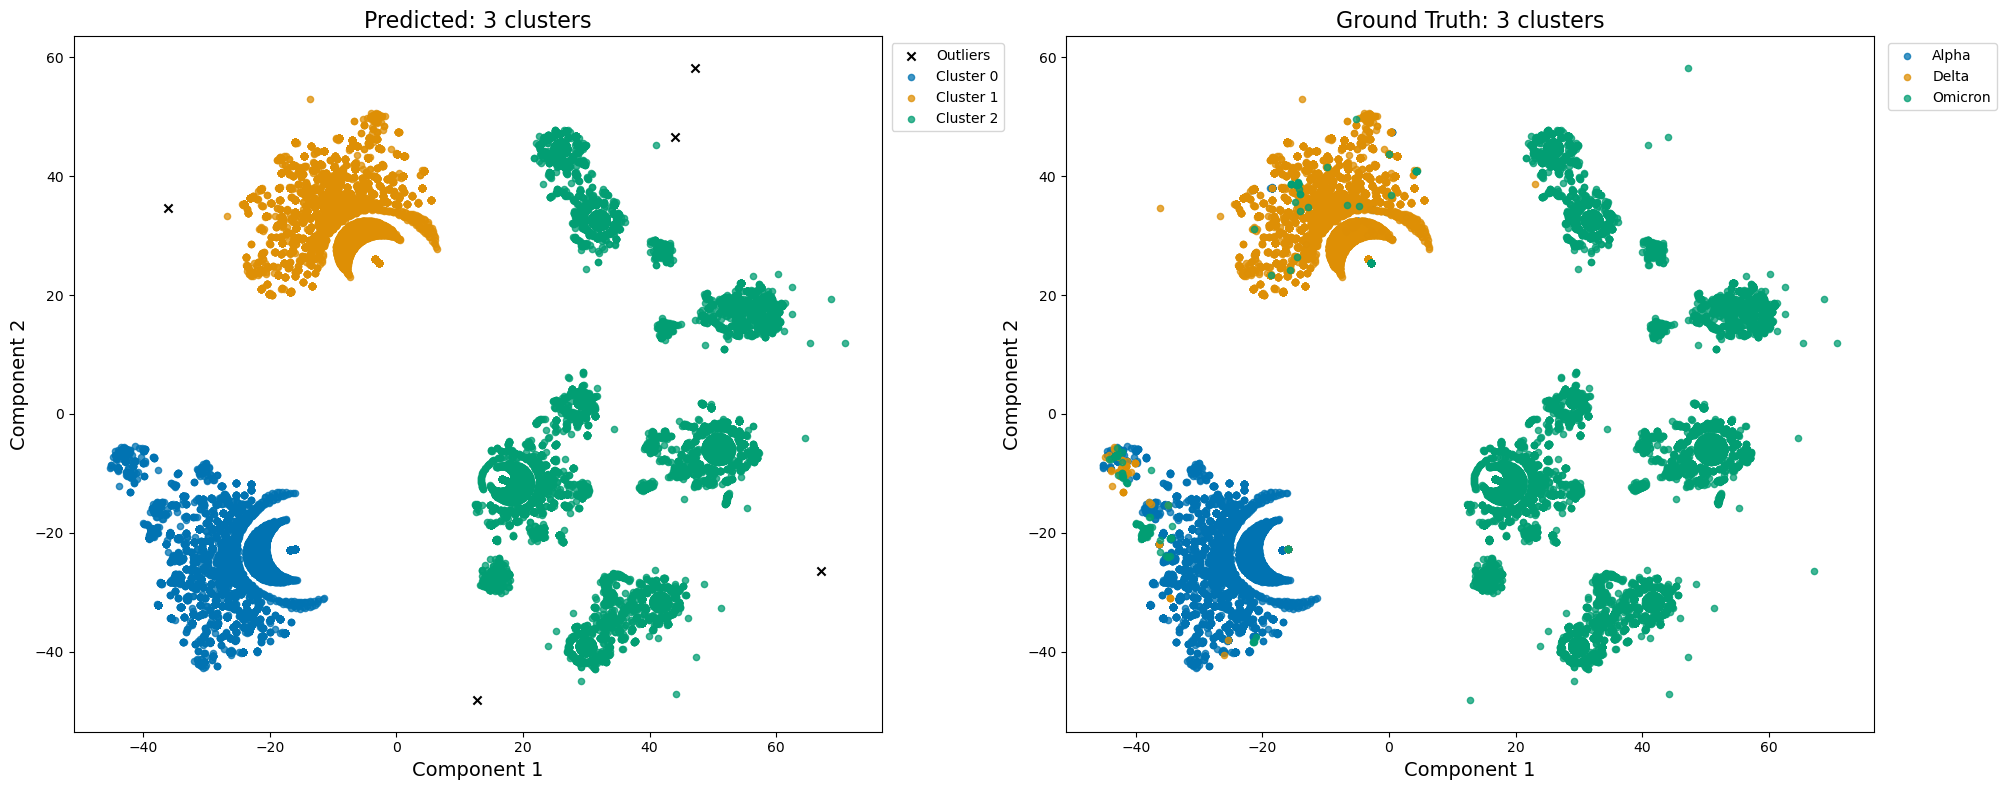

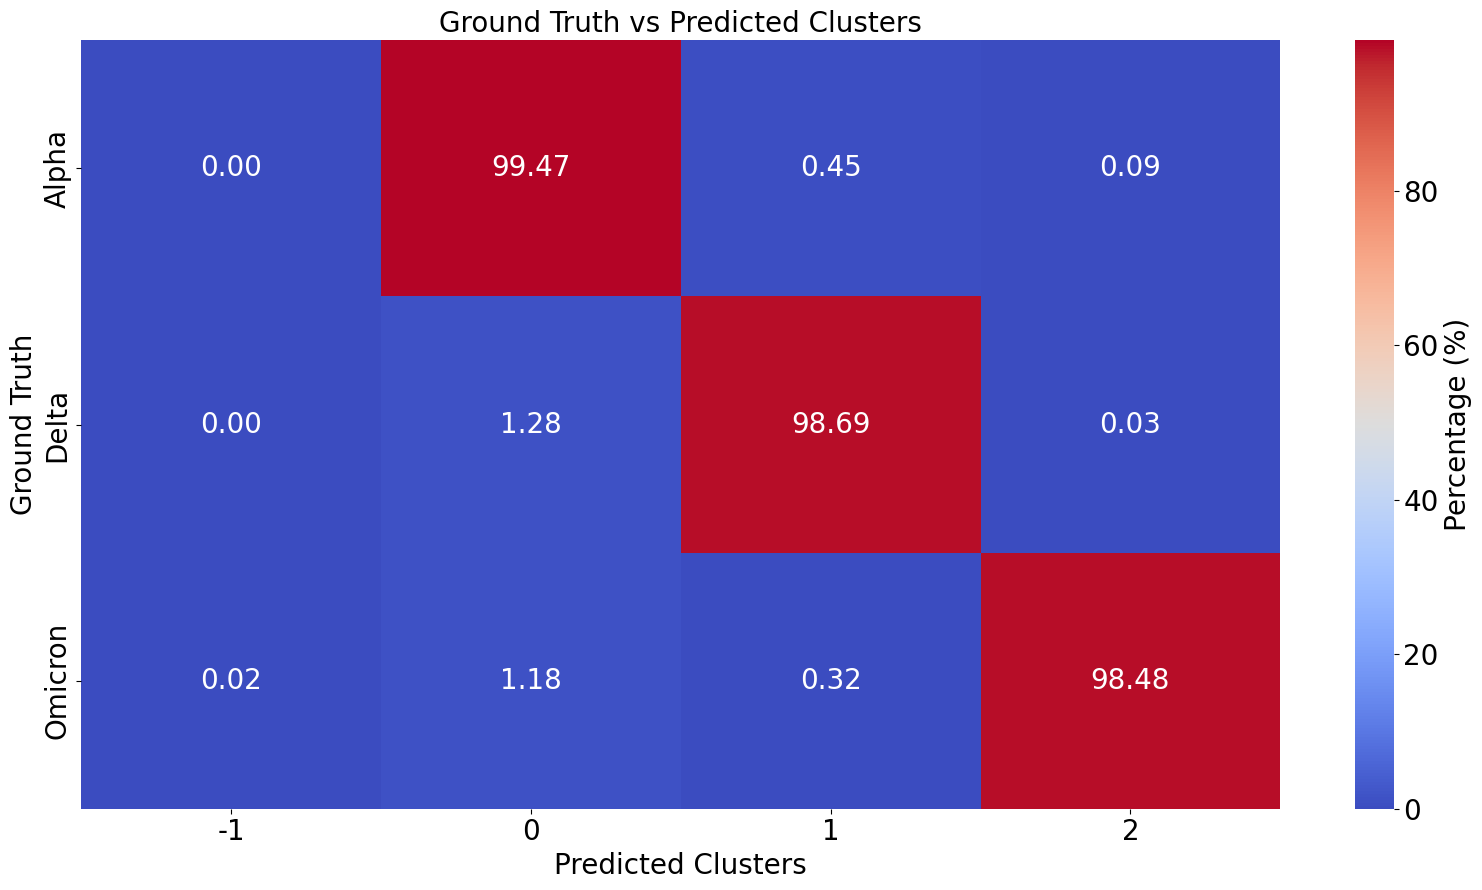

In [84]:
min_samples=1500
min_cluster_size=21000

# Cluster
hdb_labels = hdbscan.HDBSCAN(
    min_samples=min_samples,
    min_cluster_size=min_cluster_size,
    core_dist_n_jobs=-1  # Enable parallel processing
).fit(embedding_matrix_reduced).labels_

# Evaluate clustering
silhouette_avg = silhouette_score(embedding_matrix_reduced, hdb_labels)
ari = adjusted_rand_score(info_df["variant"], hdb_labels)
print(f"min_sample {min_samples}, min_cluster_size {min_cluster_size}: Silhouette Coefficient: {silhouette_avg:.2f}, Adjusted Rand Index: {ari:.2f}")
save_as = f"../../results/plots/clustering/RBD.ADO.tSNE-seed0_perp{perplexity}.HDBSCAN-ms{min_samples}_mcs{min_cluster_size}-sc{silhouette_avg:.2f}_ari{ari:.2f}"
plot_hdbscan_comparison_ado(save_as, info_df, embedding_matrix_reduced, hdb_labels, "variant", "colorblind")

# Create the truth table
plot_hdbscan_truthtable_heatmap(save_as, info_df, hdb_labels, "variant")

### Omicron only
Extract the omicron values only

In [85]:
# Load the embedding
parquet_file = os.path.join(data_dir, f"parquets/tsne_embeddings/spikeprot0528.clean.uniq.noX.RBD.metadata.variants.ADO_CLS-embedded.seed0.tsne.parquet")
embedded_ado_df = pd.read_parquet(parquet_file, engine='fastparquet')
embedded_ado_o_df = embedded_ado_df[embedded_ado_df['variant'].isin(["Omicron"])]
print(embedded_ado_o_df['variant'].value_counts())

embedding_matrix_reduced_o = embedded_ado_o_df[['DIM_1', 'DIM_2']].values
info_df_o = embedded_ado_o_df.drop(columns=['DIM_1', 'DIM_2'])

variant
Omicron    22075
Name: count, dtype: int64


In [116]:
for i in [25, 50, 100, 250, 300, 350, 400, 450, 500, 1000]:
    for j in [1000, 1250, 1500, 2000, 2500, 3000]:
        # Cluster
        hdb_labels_o = hdbscan.HDBSCAN(
            min_samples=i,
            min_cluster_size=j, 
            core_dist_n_jobs=-1  # Enable parallel processing
        ).fit(embedding_matrix_reduced_o).labels_

        # Evaluate clustering
        silhouette_avg = silhouette_score(embedding_matrix_reduced_o, hdb_labels_o)
        ari = adjusted_rand_score(info_df_o["variant"], hdb_labels_o)
        print(f"min_sample {i}, min_cluster_size {j}: (Silhouette Coefficient {silhouette_avg:.2f}, Adjusted Rand Index {ari:.2f})")

min_sample 25, min_cluster_size 1000: (Silhouette Coefficient 0.38, Adjusted Rand Index 0.00)
min_sample 25, min_cluster_size 1250: (Silhouette Coefficient 0.61, Adjusted Rand Index 0.00)
min_sample 25, min_cluster_size 1500: (Silhouette Coefficient 0.61, Adjusted Rand Index 0.00)
min_sample 25, min_cluster_size 2000: (Silhouette Coefficient 0.63, Adjusted Rand Index 0.00)
min_sample 25, min_cluster_size 2500: (Silhouette Coefficient 0.63, Adjusted Rand Index 0.00)
min_sample 25, min_cluster_size 3000: (Silhouette Coefficient 0.63, Adjusted Rand Index 0.00)
min_sample 50, min_cluster_size 1000: (Silhouette Coefficient 0.55, Adjusted Rand Index 0.00)
min_sample 50, min_cluster_size 1250: (Silhouette Coefficient 0.61, Adjusted Rand Index 0.00)
min_sample 50, min_cluster_size 1500: (Silhouette Coefficient 0.63, Adjusted Rand Index 0.00)
min_sample 50, min_cluster_size 2000: (Silhouette Coefficient 0.63, Adjusted Rand Index 0.00)
min_sample 50, min_cluster_size 2500: (Silhouette Coefficien

min_sample 400, min_cluster_size 3000: Silhouette Coefficient: 0.64, Adjusted Rand Index: 0.00


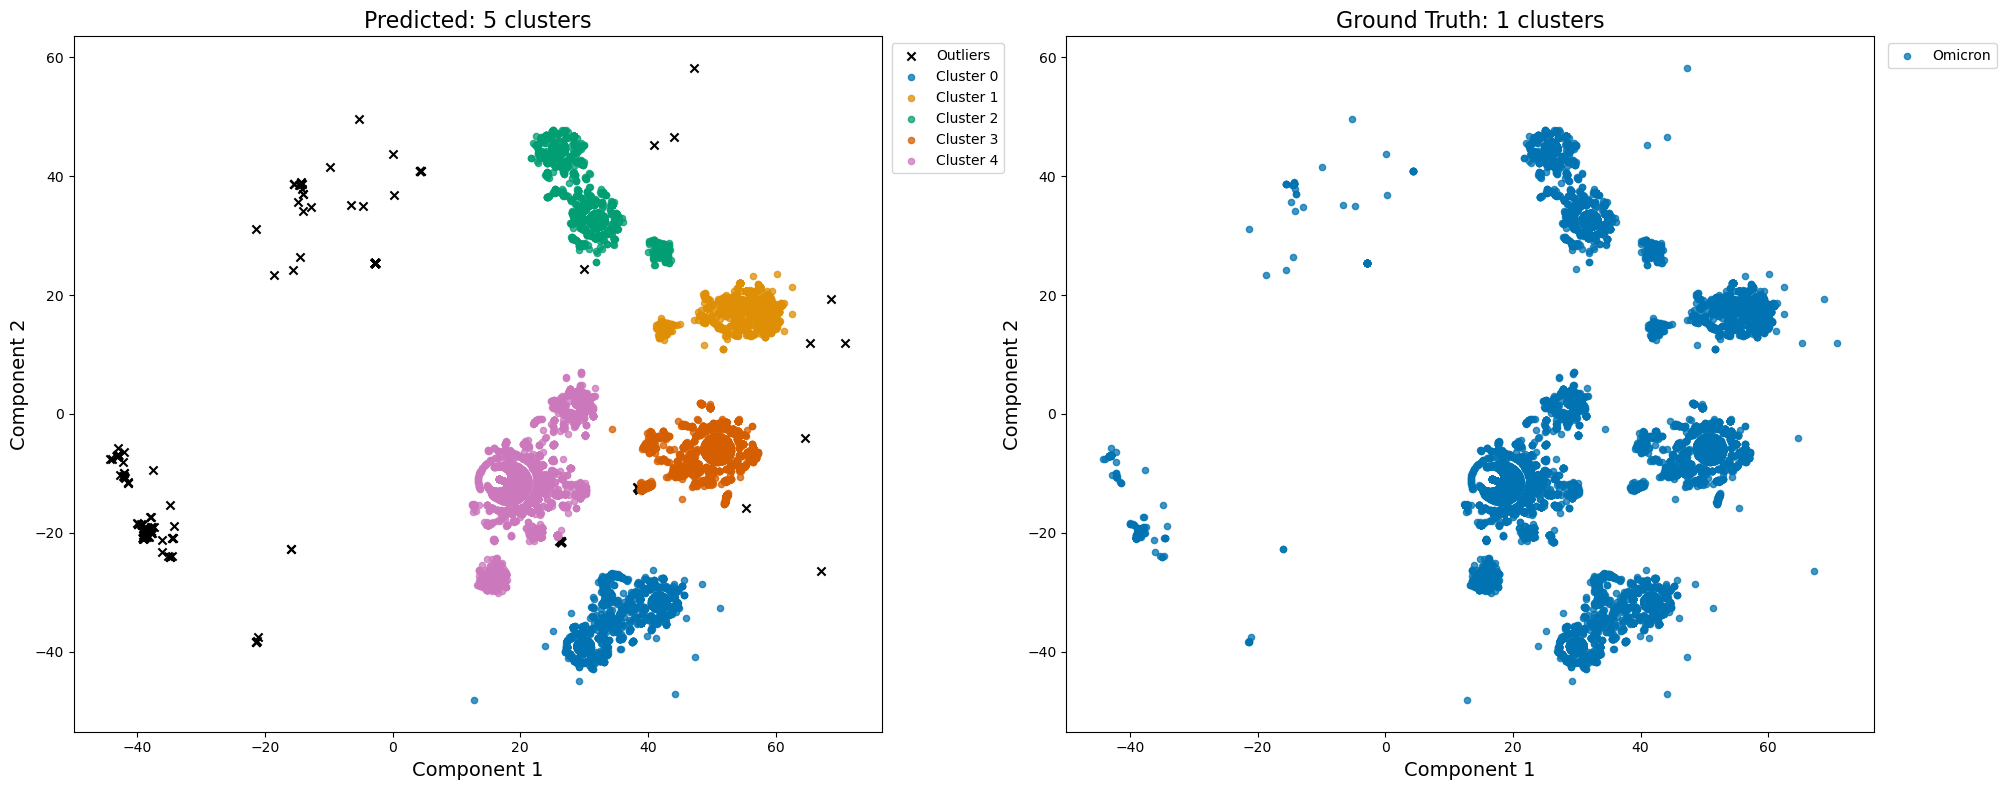

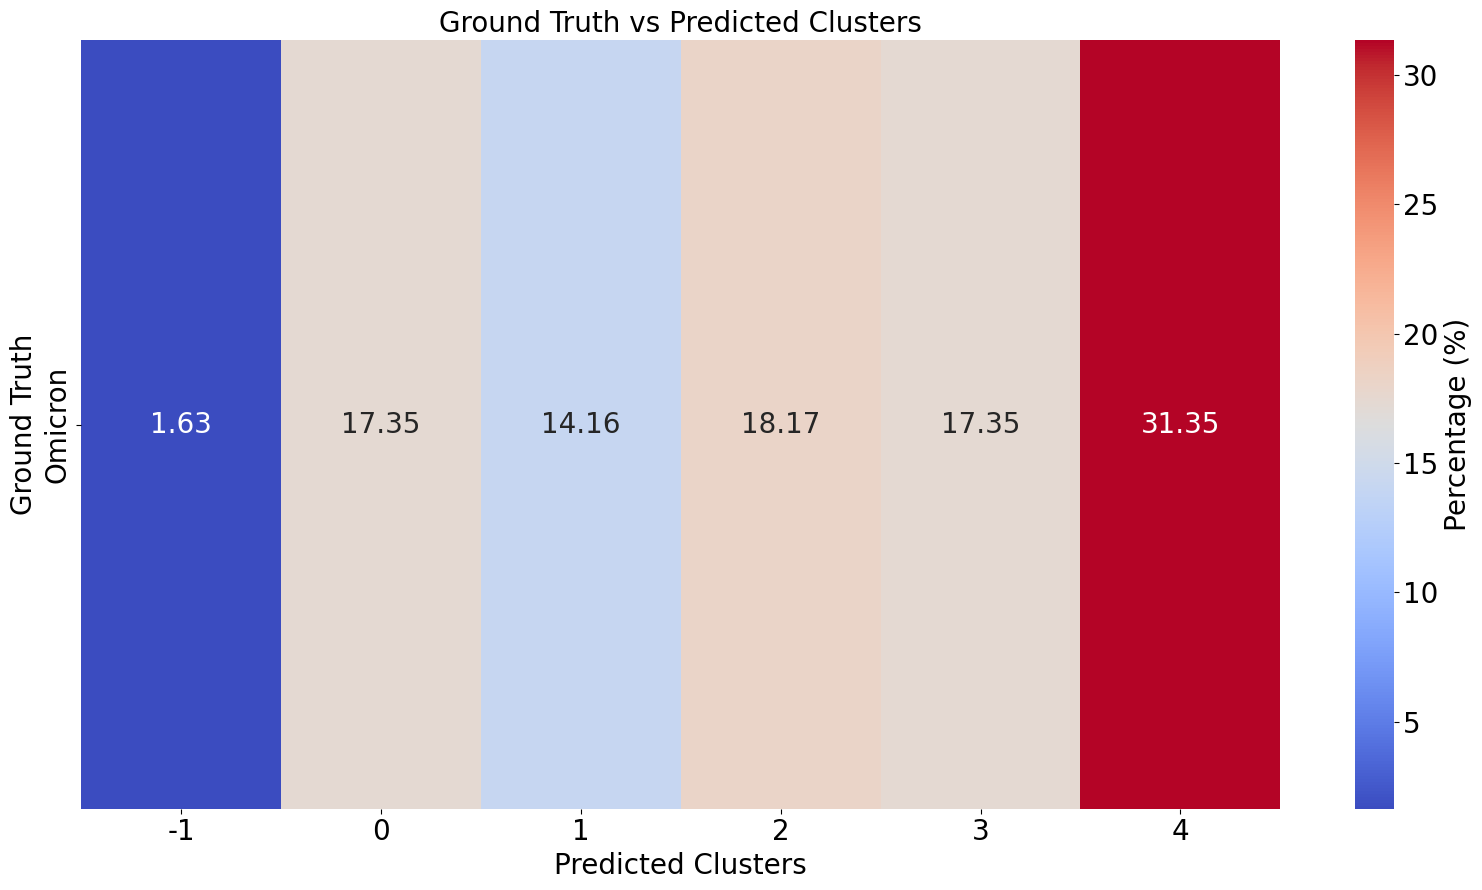

In [117]:
min_samples = 400
min_cluster_size = 3000

# Cluster
hdb_labels_o = hdbscan.HDBSCAN(
    min_samples=min_samples,
    min_cluster_size=min_cluster_size, 
    core_dist_n_jobs=-1  # Enable parallel processing
).fit(embedding_matrix_reduced_o).labels_

# Evaluate clustering
silhouette_avg = silhouette_score(embedding_matrix_reduced_o, hdb_labels_o)
ari = adjusted_rand_score(info_df_o["variant"], hdb_labels_o)
print(f"min_sample {min_samples}, min_cluster_size {min_cluster_size}: Silhouette Coefficient: {silhouette_avg:.2f}, Adjusted Rand Index: {ari:.2f}")
save_as = f"../../results/plots/clustering/RBD.ADO.O.tSNE-seed0_perp{perplexity}.HDBSCAN-ms{min_samples}_mcs{min_cluster_size}-sc{silhouette_avg:.2f}_ari{ari:.2f}"
plot_hdbscan_comparison_ado(save_as, info_df_o, embedding_matrix_reduced_o, hdb_labels_o, "variant", "colorblind")

# Create the truth table
plot_hdbscan_truthtable_heatmap(save_as, info_df_o, hdb_labels_o, "variant")

### Random seed variation

In [23]:
parquet_file = os.path.join(data_dir, "spikeprot0528.clean.uniq.noX.RBD.metadata.variants.ADO_CLS-embedded.parquet")
embedded_ado_df = pd.read_parquet(parquet_file, engine='fastparquet')

# Random sampling
min_sample_size = embedded_ado_df['variant'].value_counts().min()
sample_sizes = {"Alpha": min_sample_size,
                "Delta": min_sample_size,
                "Omicron": min_sample_size}

for i in range(12):
    rnd_seed = i
    sampled_dfs = [embedded_ado_df[embedded_ado_df['variant'] == variant].sample(n=sample_sizes[variant], random_state=rnd_seed)
                            for variant in sample_sizes.keys()]
    sampled_ado_df = pd.concat(sampled_dfs)
    save_as = os.path.join(data_dir, f"parquets/spikeprot0528.clean.uniq.noX.RBD.metadata.variants.ADO_CLS-embedded.seed{rnd_seed}.parquet")
    sampled_ado_df.to_parquet(save_as, index=False)

In [ ]:
for i in range(12):    
    # Load in the data
    parquet_file = os.path.join(data_dir, f"parquets/spikeprot0528.clean.uniq.noX.RBD.metadata.variants.ADO_CLS-embedded.seed{i}.parquet")
    embedded_ado_df = pd.read_parquet(parquet_file, engine='fastparquet')
    embedding_matrix = np.vstack(embedded_ado_df["embedding"])
    info_df = embedded_ado_df.drop(columns=["embedding"])

    # Apply tSNE to reduce the dimensionality of the embedding matrix, took ~ 13 min
    perplexity = round(len(info_df) * 0.01) # find source for 1%
    tsne_reducer = TSNE(n_components=2, perplexity=perplexity, learning_rate='auto', random_state=0)
    embedding_matrix_reduced = tsne_reducer.fit_transform(embedding_matrix)


### All Omicron data

Extract out all of the Omicron data.

In [119]:
parquet_file = os.path.join(data_dir, "spikeprot0528.clean.uniq.noX.RBD.metadata.variants.ADO_CLS-embedded.parquet")
embedded_ado_df = pd.read_parquet(parquet_file, engine='fastparquet')

# Extract Omicron only
embedded_o_df = embedded_ado_df[embedded_ado_df['variant'].isin(["Omicron"])]
print(embedded_o_df['variant'].value_counts())

save_as = os.path.join(data_dir, f"parquets/embeddings/spikeprot0528.clean.uniq.noX.RBD.metadata.variants.O_CLS-embedded.parquet")
embedded_o_df.to_parquet(save_as, index=False)

variant
Omicron    160016
Name: count, dtype: int64
